In [1]:
import os
os.chdir('/home/s3/hyeryung/mucoco')

import argparse
import json
import logging
import time

import pandas as pd
import numpy as np
import torch
import transformers
from sentence_transformers import SentenceTransformer
from transformers import AutoConfig, AutoModelForMaskedLM, AutoTokenizer, AutoModelForSequenceClassification

import mucoco.utils as utils
import new_module.losses as lossbuilder
import wandb
from new_module.decode_utils import beam_rerank_v0, beam_rerank_v1, beam_rerank_v2, combi_rerank
from new_module.evaluation.evaluate_wandb import evaluate
from new_module.locate.locate_utils import locate_main
from new_module.locate.locate_utils_original import locate_main_original
from new_module.utils.robertacustom import RobertaCustomForSequenceClassification

PyTorch version 2.1.2 available.


In [2]:
logging.basicConfig(level=logging.DEBUG, format="%(message)s")
logger = logging.getLogger(__name__)
logger.setLevel(os.environ.get("LOGGING_LEVEL", logging.DEBUG))

In [3]:
config={#'model_paths':['gpt2-large','/shared/s3/lab07/hyeryung/loc_edit/roberta-base-jigsaw-toxicity-classifier-energy-training/step_600_best_checkpoint'],
        # 'tokenizer_paths':['gpt2-large','/shared/s3/lab07/hyeryung/loc_edit/roberta-base-jigsaw-toxicity-classifier-energy-training/step_600_best_checkpoint'],
        'model_paths':['gpt2-large','/shared/s3/lab07/hyeryung/loc_edit/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds-energy-training/step_2800_best_checkpoint/'],
        'tokenizer_paths':['gpt2-large','/shared/s3/lab07/hyeryung/loc_edit/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds-energy-training/step_2800_best_checkpoint/'],
        'model_types': ["AutoModelForCausalLM", "AutoModelForSequenceClassification"],
        'cache_dir': "hf_cache",
        'target_type': "embeds",
        'method': "mlm-beamsearch-v0",
       'losses': ["gpt2", "classification_no_prefix_logprobloss"],
       'target_label_ids': [0,0] ,
       'build_loss_dict': {"coeff_steps": 200, "coeff_pattern": "constant", "loss_type": "xentropy", "length_normalize": False, "AR_temperature": 1.0, "AR_top_k": 0, "AR_top_p": 0.96, "max_output_length": 20},
       'min_epsilons': [0.75],
       'source_data': 'new_module/data/toxicity-avoidance/testset_gpt2_2500.jsonl',
       'locate_unit': 'word',
       'locate_method': 'grad_norm',
       'device': 'cuda',
       'k_per_location': 3,
       'closs_weight': 0.9}

In [4]:
# model = 

In [33]:
import torch.nn.functional as F 

from datasets import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import recall_score, precision_score, accuracy_score

model = AutoModelForSequenceClassification.from_pretrained('/shared/s3/lab07/hyeryung/loc_edit/roberta-base-jigsaw-toxicity-classifier-energy-training/step_600_best_checkpoint')
tokenizer = AutoTokenizer.from_pretrained('/shared/s3/lab07/hyeryung/loc_edit/roberta-base-jigsaw-toxicity-classifier-energy-training/step_600_best_checkpoint')

def collate_fn(batch):
    text_input = [example['text'] for example in batch]
    return tokenizer(text_input, truncation=True, padding=True, return_tensors="pt")

test_data_path='/shared/s3/lab07/hyeryung/loc_edit/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/test.jsonl'
test_data = pd.read_json(test_data_path,lines=True)
test_data['labels_binary']=test_data['labels'].apply(lambda x: 1 if x>=0.5 else 0)


# ----------------------------------------------------------------------------------------------------- # 
test_dataset=Dataset.from_pandas(test_data)
test_dataloader=DataLoader(test_dataset,batch_size=24,collate_fn=collate_fn, shuffle=False)

scores=[]
with torch.no_grad():
    for _batch in test_dataloader:
        logits=model(**_batch).logits
        softmax_outputs=F.softmax(logits, dim=-1)
        scores.append(softmax_outputs[:, 1])
        torch.cuda.empty_cache()
        del softmax_outputs
        del logits
        
scores_torch=torch.cat(scores,dim=0)
test_data['scores_nes']=scores_torch.tolist()
test_data['scores_nes_binary']=test_data['scores_nes'].apply(lambda x: 1 if x >= 0.5 else 0)

print(f"recall: {recall_score(test_data['labels_binary'],test_data['scores_nes_binary']):.3f}")
print(f"precision: {precision_score(test_data['labels_binary'], test_data['scores_nes_binary']):.3f}")
print(f"accuracy: {accuracy_score(test_data['labels_binary'], test_data['scores_nes_binary']):.3f}")

recall: 0.835
precision: 0.946
accuracy: 0.894


In [34]:
model = RobertaCustomForSequenceClassification.from_pretrained('/shared/s3/lab07/hyeryung/loc_edit/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds-energy-training/step_2800_best_checkpoint/')
tokenizer = AutoTokenizer.from_pretrained('/shared/s3/lab07/hyeryung/loc_edit/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds-energy-training/step_2800_best_checkpoint/')

def collate_fn(batch):
    text_input = [example['text'] for example in batch]
    return tokenizer(text_input, truncation=True, padding=True, return_tensors="pt")

test_dataset=Dataset.from_pandas(test_data)
test_dataloader=DataLoader(test_dataset,batch_size=24,collate_fn=collate_fn, shuffle=False)

scores=[]
with torch.no_grad():
    for _batch in test_dataloader:
        logits=model(**_batch).logits
        softmax_outputs=F.softmax(logits, dim=-1)
        scores.append(softmax_outputs[:, 1])
        torch.cuda.empty_cache()
        del softmax_outputs
        del logits
        
scores_torch=torch.cat(scores,dim=0)
test_data['scores_es']=scores_torch.tolist()
test_data['scores_es_binary']=test_data['scores_es'].apply(lambda x: 1 if x >= 0.5 else 0)

print(f"recall: {recall_score(test_data['labels_binary'],test_data['scores_es_binary']):.3f}")
print(f"precision: {precision_score(test_data['labels_binary'], test_data['scores_es_binary']):.3f}")
print(f"accuracy: {accuracy_score(test_data['labels_binary'], test_data['scores_es_binary']):.3f}")

50265
recall: 0.755
precision: 0.978
accuracy: 0.870


In [36]:
from seaborn import displot

Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/home/s3/hyeryung/miniconda3/envs/loc-edit/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/home/s3/hyeryung/miniconda3/envs/loc-edit/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/s3/hyeryung/miniconda3/envs/loc-edit/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=4

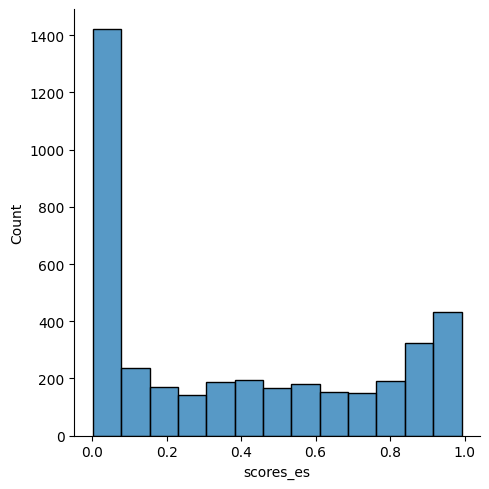

In [38]:
displot(test_data['scores_es'])

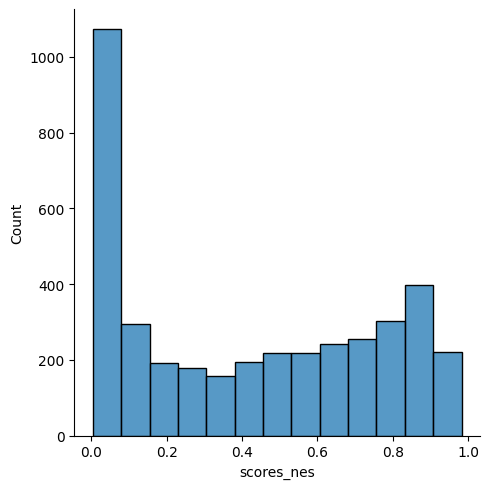

In [40]:
displot(test_data['scores_nes'])

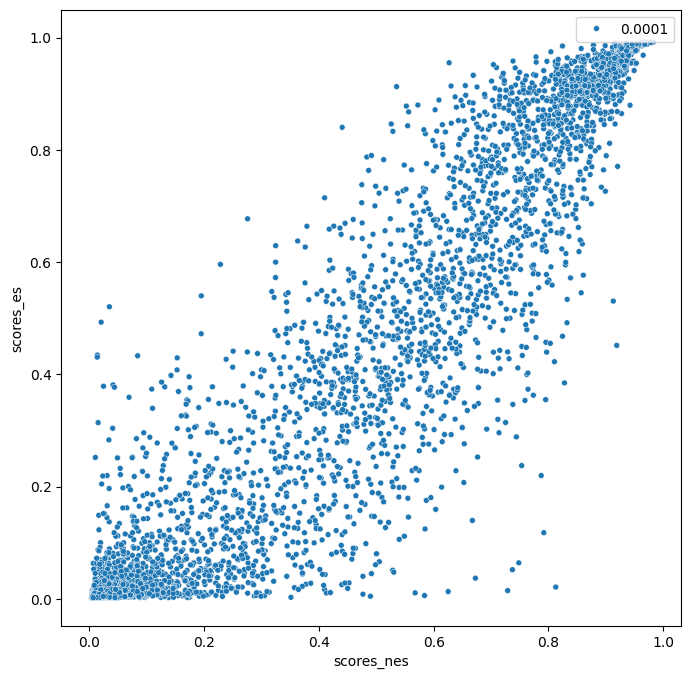

In [59]:
fig,ax=plt.subplots(figsize=(8,8))
ax=scatterplot(test_data, x='scores_nes', y='scores_es',size=0.0001,ax=ax)
ax.plot((0,0),(1,1), color='r', linestyle='-', linewidth=2)